In [1]:
import pandas as pd
import numpy as np
import os
import sys
import soundfile as sf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [18]:
import os
import pandas as pd

# Tentukan path folder dataset
dataset_path = "./Dataset/Original/"

# Buat list untuk menyimpan data
file_emotions = []
file_paths = []

# Dictionary untuk mapping nama folder ke emosi
emotion_dict = {
    'angry': 'angry',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad'
}

# Iterasi melalui folder dataset
for dirpath, dirnames, filenames in os.walk(dataset_path):
    for file in filenames:
        if file.endswith('.wav'):
            # Ekstrak emosi dari nama folder
            emotion_folder = os.path.basename(dirpath).split('_')[1].lower()
            emotion = emotion_dict.get(emotion_folder)
            if emotion:
                file_emotions.append(emotion)
                file_paths.append(os.path.join(dirpath, file))
            else:
                print(f"Emosi tidak ditemukan untuk folder: {dirpath}")

# Buat DataFrame
emotion_df = pd.DataFrame({
    'Emotions': file_emotions,
    'Path': file_paths
})

# Tampilkan beberapa baris dari DataFrame untuk verifikasi
print(emotion_df.head())
print(emotion_df.tail())


  Emotions                                              Path
0      sad  ./Dataset/Original/Male\OAF_Sad\OAF_back_sad.wav
1      sad   ./Dataset/Original/Male\OAF_Sad\OAF_bar_sad.wav
2      sad  ./Dataset/Original/Male\OAF_Sad\OAF_base_sad.wav
3      sad  ./Dataset/Original/Male\OAF_Sad\OAF_bath_sad.wav
4      sad  ./Dataset/Original/Male\OAF_Sad\OAF_bean_sad.wav
     Emotions                                               Path
1995  neutral  ./Dataset/Original/Female\YAF_neutral\YAF_witc...
1996  neutral  ./Dataset/Original/Female\YAF_neutral\YAF_year...
1997  neutral  ./Dataset/Original/Female\YAF_neutral\YAF_yes_...
1998  neutral  ./Dataset/Original/Female\YAF_neutral\YAF_youn...
1999  neutral  ./Dataset/Original/Female\YAF_neutral\YAF_yout...


In [19]:
print("Total data entries:", len(emotion_df))


Total data entries: 2000


In [20]:
print("Duplicate entries:", emotion_df.duplicated().sum())


Duplicate entries: 0


In [21]:
print(emotion_df['Emotions'].value_counts())


Emotions
sad        400
neutral    400
happy      400
angry      400
fear       400
Name: count, dtype: int64


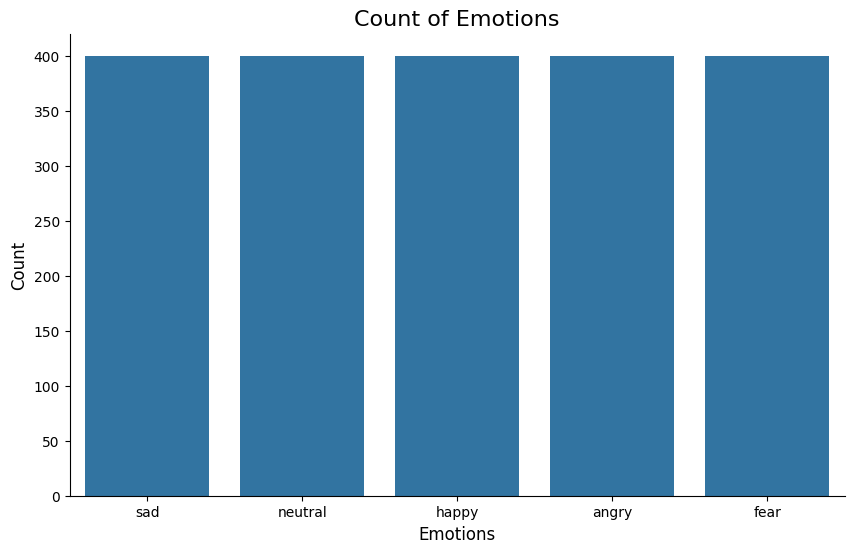

In [22]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=emotion_df, order=emotion_df['Emotions'].value_counts().index)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [23]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

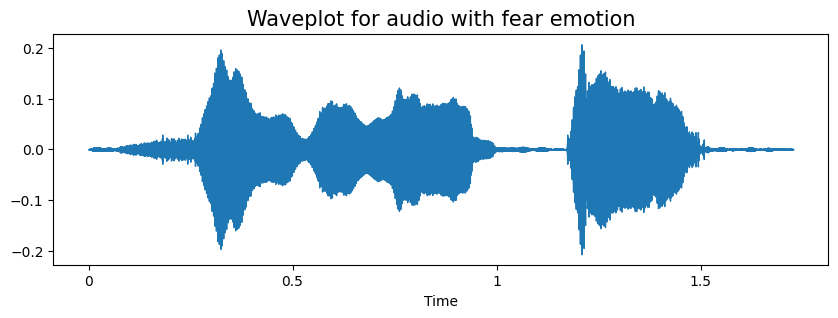

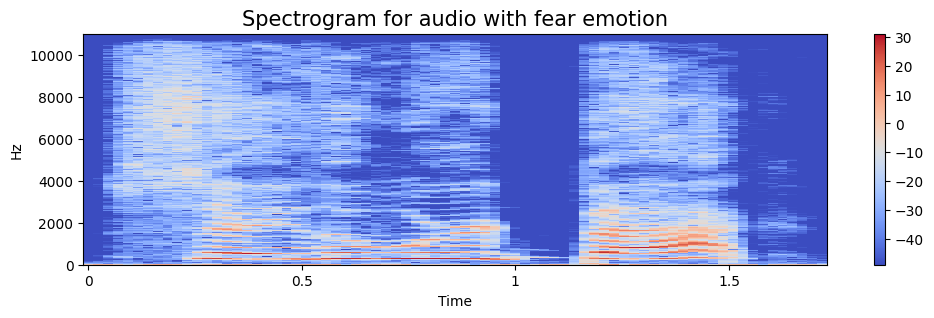

In [24]:
emotion = 'fear'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(data, rate=sampling_rate))
    Audio(path)

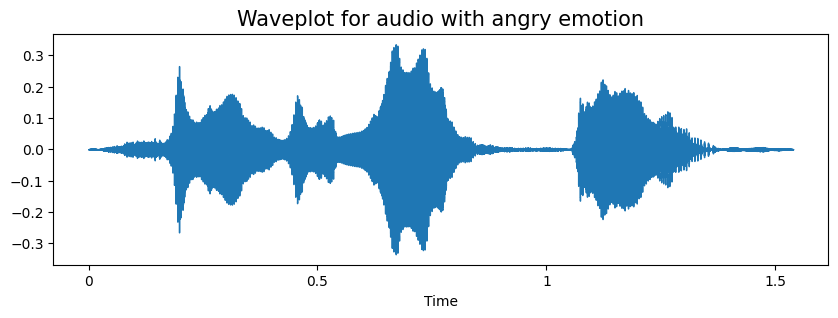

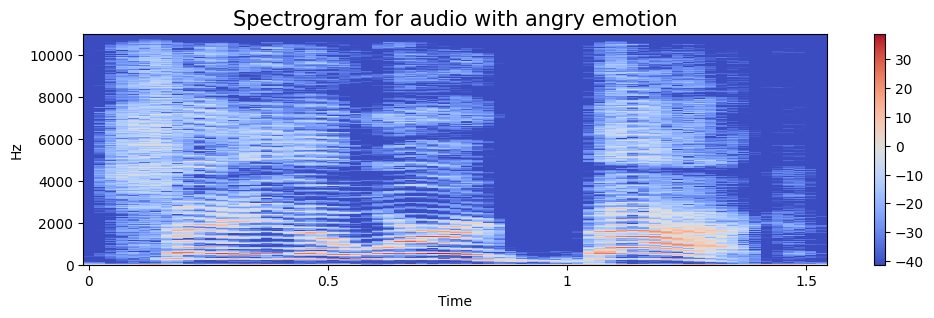

In [25]:
emotion = 'angry'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(data, rate=sampling_rate))
    Audio(path)

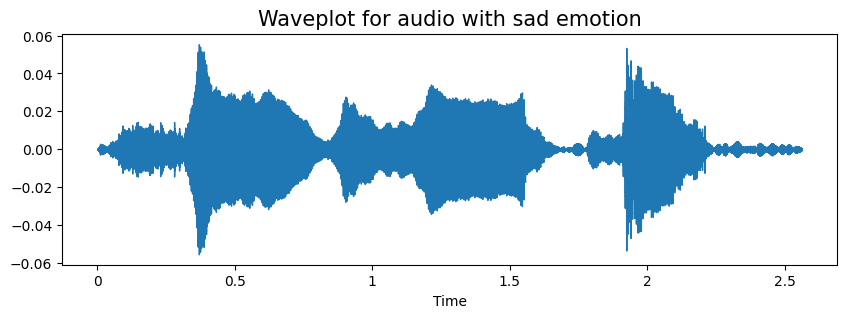

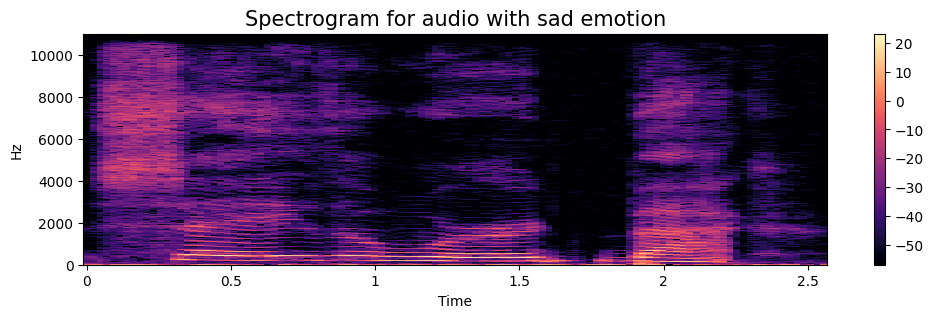

In [26]:
emotion = 'sad'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(data, rate=sampling_rate))
    Audio(path)

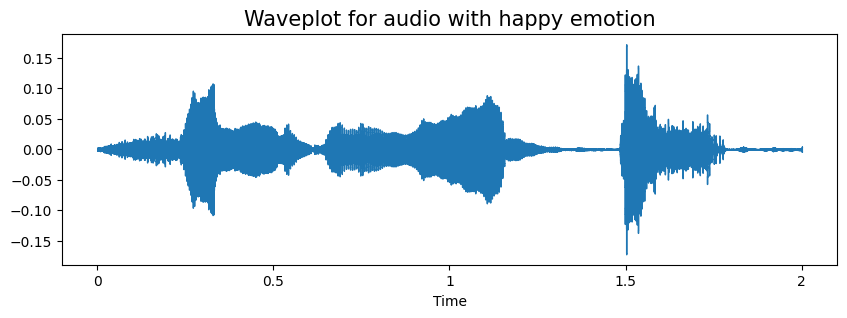

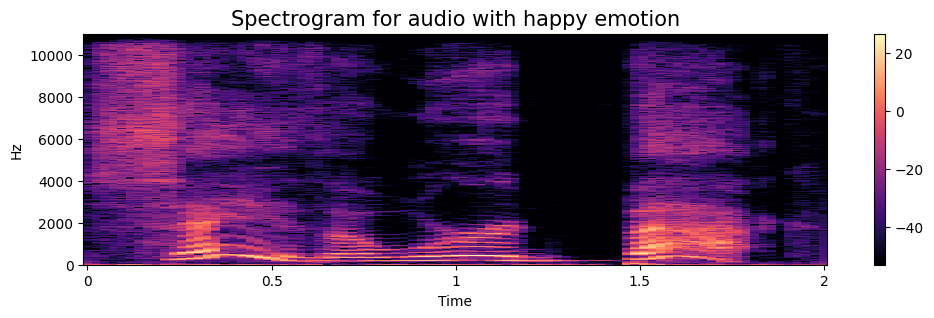

In [27]:
emotion = 'happy'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(data, rate=sampling_rate))
    Audio(path)

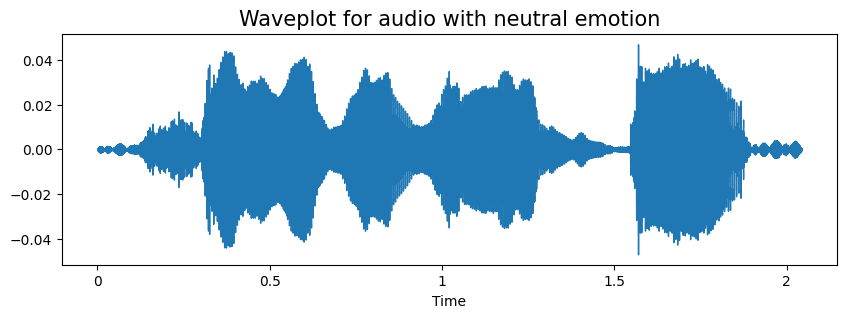

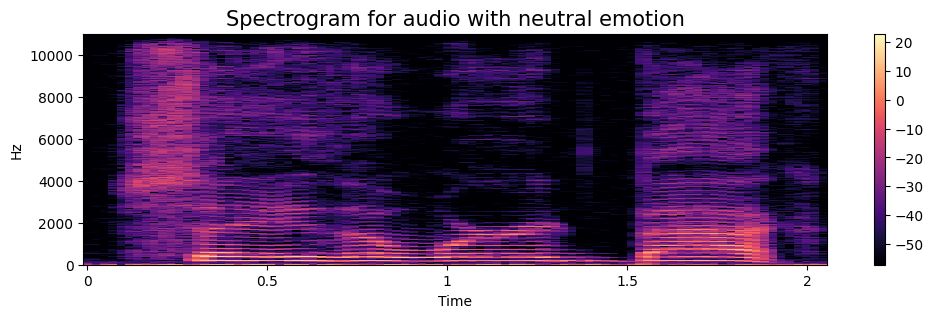

In [34]:
emotion = 'neutral'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(data, rate=sampling_rate))
    Audio(path)

Preprocessing Augmentasi

In [37]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

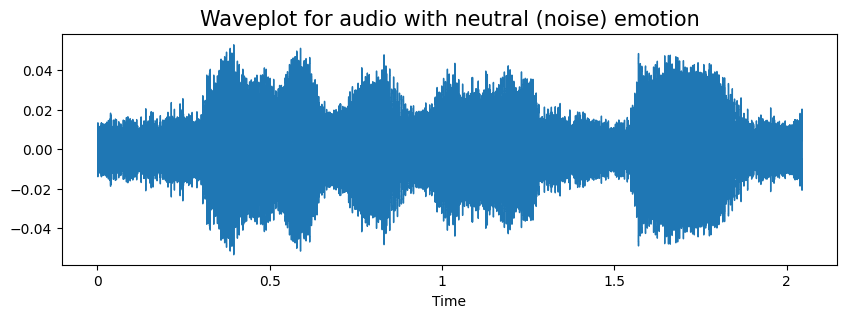

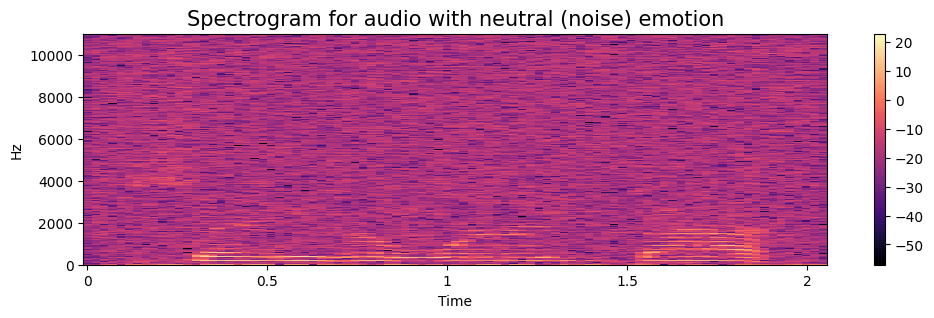

In [51]:
def augment_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def visualize_audio(data, sr, emotion, augmentation_type):
    create_waveplot(data, sr, f'{emotion} ({augmentation_type})')
    create_spectrogram(data, sr, f'{emotion} ({augmentation_type})')
    display(Audio(data, rate=sr))

emotion = 'neutral'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    
    # Augmentasi Noise
    augmented_data = augment_noise(data)
    visualize_audio(augmented_data, sampling_rate, emotion, 'noise')


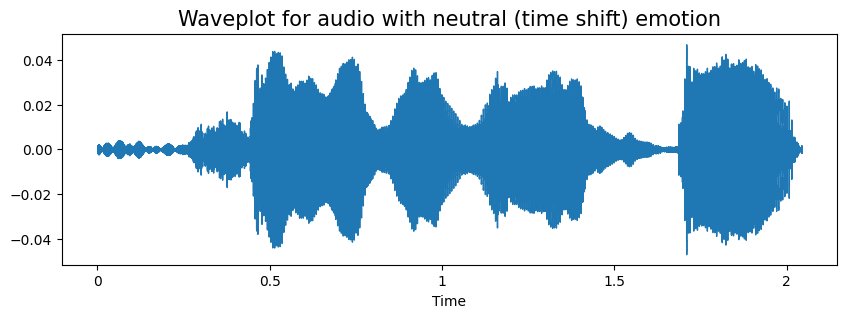

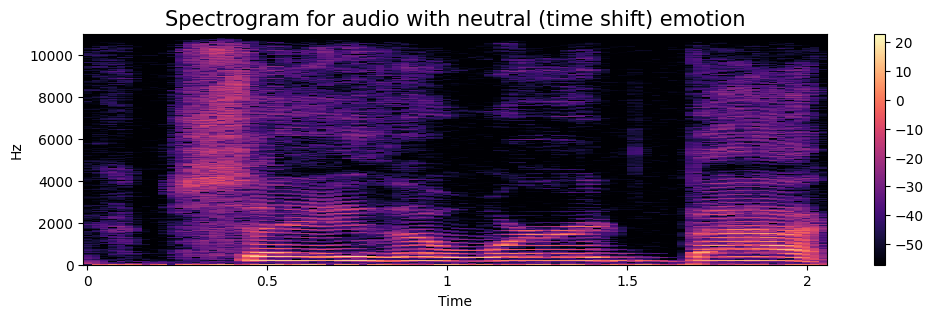

In [53]:
def augment_time_shift(data, shift_max=0.2):
    shift = np.random.randint(data.shape[0] * shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

emotion = 'neutral'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    
    # Augmentasi Time Shift
    augmented_data = augment_time_shift(data)
    visualize_audio(augmented_data, sampling_rate, emotion, 'time shift')


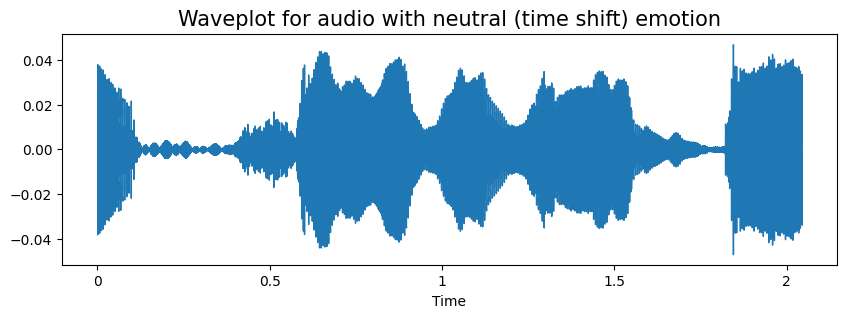

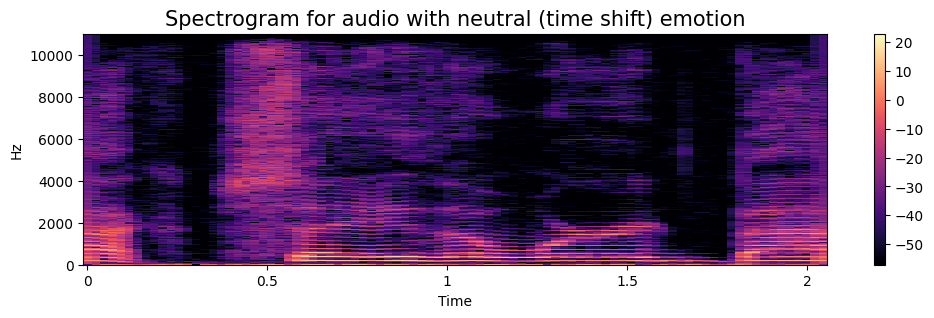

In [58]:
def augment_time_shift(data, shift_max=0.2):
    shift = np.random.randint(data.shape[0] * shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

emotion = 'neutral'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    
    # Augmentasi Time Shift
    augmented_data = augment_time_shift(data)
    visualize_audio(augmented_data, sampling_rate, emotion, 'time shift')


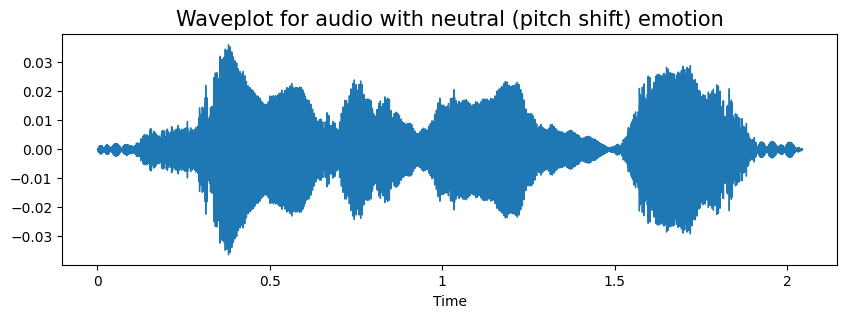

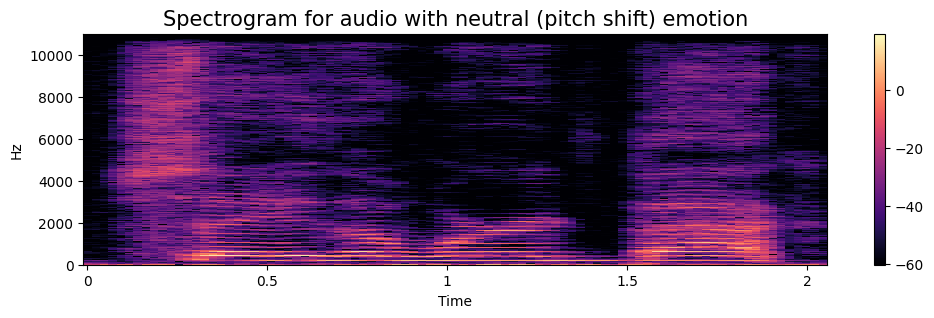

In [62]:
def augment_pitch_shift(data, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

emotion = 'neutral'
emotion_paths = emotion_df.Path[emotion_df.Emotions == emotion]

if len(emotion_paths) > 0:
    path = emotion_paths.iloc[0]
    data, sampling_rate = librosa.load(path)
    
    # Augmentasi Pitch Shift
    augmented_data = augment_pitch_shift(data, sampling_rate, pitch_factor=2)
    visualize_audio(augmented_data, sampling_rate, emotion, 'pitch shift')


In [76]:
# Tentukan path folder dataset
dataset_path = "./Dataset"
augmented_path = "./Augmented_Dataset"

In [82]:
# Fungsi untuk menambahkan noise pada data audio
def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Fungsi untuk meregangkan (stretch) data audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Fungsi untuk menggeser (shift) data audio
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# Fungsi untuk mengubah pitch data audio
def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = int(pitch_factor * 12)  # Mengonversi pitch_factor ke semitone
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)


In [83]:
# Fungsi untuk menyimpan data audio
def save_audio(data, path, sample_rate):
    sf.write(path, data, sample_rate)

In [89]:
# Fungsi untuk mengaugmentasi dan menyimpan data
def augment_and_save(data, sample_rate, file_name, emotion, output_dir):
    # Tambah noise
    noisy_data = add_noise(data)
    save_audio(noisy_data, os.path.join(output_dir, emotion, f"noisy_{file_name}"), sample_rate)
    
    # Shift data
    shifted_data = shift(data)
    save_audio(shifted_data, os.path.join(output_dir, emotion, f"shifted_{file_name}"), sample_rate)
    
    # Pitch shift data
    pitched_data = pitch(data, sample_rate, pitch_factor=0.7)
    save_audio(pitched_data, os.path.join(output_dir, emotion, f"pitched_{file_name}"), sample_rate)
    
    # Stretch data
    stretched_data = stretch(data, rate=0.8)
    save_audio(stretched_data, os.path.join(output_dir, emotion, f"stretched_{file_name}"), sample_rate)

In [90]:
# folder untuk hasil augmentasi sudah ada
for emotion in emotion_dict.values():
    emotion_folder = os.path.join(augmented_path, emotion)
    if not os.path.exists(emotion_folder):
        os.makedirs(emotion_folder)

In [91]:
# Loop melalui DataFrame untuk mengaugmentasi dan menyimpan setiap audio
for index, row in emotion_df.iterrows():
    path = row['Path']
    emotion = row['Emotions']
    file_name = os.path.basename(path)
    data, sample_rate = librosa.load(path)
    
    # Augmentasi dan simpan data
    augment_and_save(data, sample_rate, file_name, emotion, augmented_path)

In [92]:
# Inisialisasi list untuk menyimpan data yang akan di-append ke DataFrame
augmented_data = []

# Iterasi melalui folder augmented_path untuk mengumpulkan data
for dirpath, dirnames, filenames in os.walk(augmented_path):
    for file in filenames:
        if file.endswith('.wav'):
            emotion = emotion_dict.get(file.split('-')[0])
            path = os.path.join(dirpath, file)
            augmented_data.append({'Emotions': emotion, 'Path': path})

# Buat DataFrame dari list augmented_data
augmented_df = pd.DataFrame(augmented_data)

# Hitung jumlah data yang telah di-augmentasi
augmented_count = len(augmented_df)

# Cetak jumlah data yang telah di-augmentasi
print(f"Augmented data count: {augmented_count}")


Augmented data count: 8001


Normalisasi 

In [71]:
# Fungsi untuk normalisasi data
def normalize(data):
    scaler = StandardScaler()
    # Reshape data untuk sesuai dengan input scaler
    data = data.reshape(-1, 1)
    normalized_data = scaler.fit_transform(data)
    # Kembalikan data ke bentuk asli
    normalized_data = normalized_data.reshape(-1)
    return normalized_data

In [72]:
# Contoh normalisasi pada data audio
normalized_data = normalize(data)


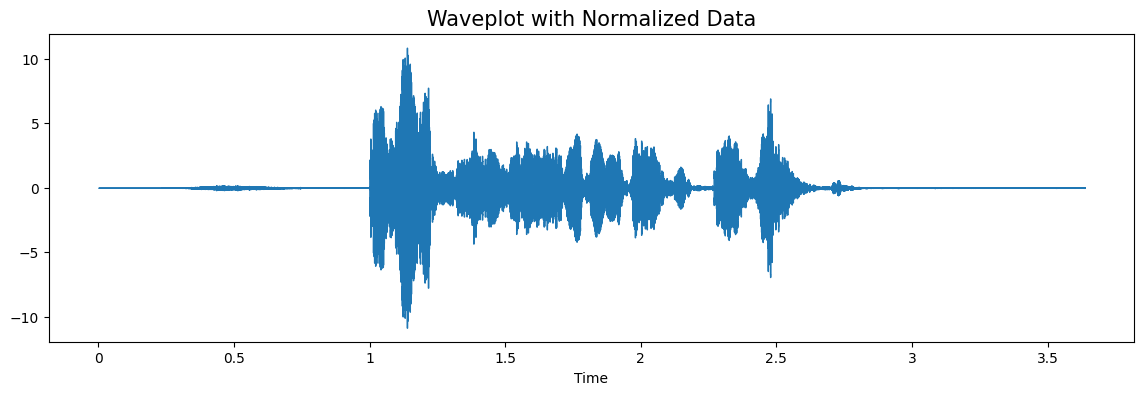

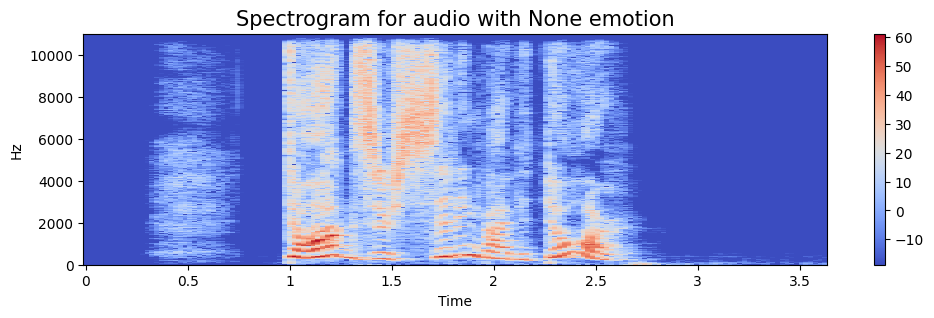

In [73]:
# Plot waveplot dengan audio hasil normalisasi
plt.figure(figsize=(14, 4))
plt.title('Waveplot with Normalized Data', size=15)
librosa.display.waveshow(normalized_data, sr=sample_rate)
plt.show()

# Plot spectrogram dengan audio hasil normalisasi
create_spectrogram(normalized_data, sample_rate, emotion)

# Tampilkan audio hasil normalisasi
display(Audio(normalized_data, rate=sample_rate))

Extraction Feature

In [119]:
import glob
# Fungsi untuk ekstraksi fitur MFCC
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

In [148]:
# Fungsi untuk ekstraksi fitur MFCC
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    # Mel-Frequency Cepstral Coefficients
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

# Fungsi untuk menghasilkan fitur dari semua file dalam dataset berdasarkan kelas emosi
def generate_features_and_labels(dataset_path):
    all_features = []
    emotion_dict = ['angry', 'fear', 'happy', 'neutral', 'sad']
    dataset_types = ['Original', 'Augmentasi_Dataset']

    for dataset_type in dataset_types:
        dataset_folder_path = os.path.join(dataset_path, dataset_type)
        if not os.path.exists(dataset_folder_path):
            print(f"Folder {dataset_type} tidak ditemukan di {dataset_path}")
            continue

        for emotion_folder in emotion_dict:
            emotion_folder_path = os.path.join(dataset_folder_path, emotion_folder)
            if not os.path.exists(emotion_folder_path):
                continue

            files_audio = glob.glob(f'{emotion_folder_path}/*.wav')
            if len(files_audio) == 0:
                print(f"Tidak ada file audio ditemukan di {emotion_folder_path}")
            else:
                print(f'Processing {len(files_audio)} audio files in {emotion_folder} emotion ({dataset_type})...')

            for f in files_audio:
                try:
                    features = extract_features(f)
                    if features is not None:
                        all_features.append([f] + features.tolist())
                except Exception as e:
                    print(f"Error processing {f}: {str(e)}")

    return all_features

# Tentukan path folder dataset
dataset_path = "./Dataset"

# Panggil fungsi untuk menghasilkan fitur
features_with_filenames = generate_features_and_labels(dataset_path)

# Buat DataFrame dari fitur-fitur tersebut
column_names = ['filename'] + [f'mfcc_{i}' for i in range(1, 14)]
df = pd.DataFrame(features_with_filenames, columns=column_names)

# Contoh untuk melihat hasilnya
print(df.head())


Processing 1600 audio files in angry emotion (Augmentasi_Dataset)...
Processing 1600 audio files in fear emotion (Augmentasi_Dataset)...
Processing 1600 audio files in happy emotion (Augmentasi_Dataset)...
Processing 1600 audio files in neutral emotion (Augmentasi_Dataset)...
Processing 1600 audio files in sad emotion (Augmentasi_Dataset)...
                                            filename      mfcc_1     mfcc_2  \
0  ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -364.978638  47.455189   
1  ./Dataset\Augmentasi_Dataset\angry\shifted_OAF... -381.181732  52.730801   
2  ./Dataset\Augmentasi_Dataset\angry\pitched_OAF... -408.738831  31.637667   
3  ./Dataset\Augmentasi_Dataset\angry\stretched_O... -405.810852  59.821888   
4  ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -299.509186  27.790228   

      mfcc_3     mfcc_4    mfcc_5     mfcc_6     mfcc_7    mfcc_8     mfcc_9  \
0 -15.612601 -12.164760 -3.849560   7.157230 -22.065310 -6.603796  -9.113241   
1 -17.242031 -11.5399

In [149]:
df

,filename,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b...,-364.978638,47.455189,-15.612601,-12.164760,-3.849560,7.157230,-22.065310,-6.603796,-9.113241,-3.565475,0.978536,0.263304,2.218435
1,./Dataset\Augmentasi_Dataset\angry\shifted_OAF...,-381.181732,52.730801,-17.242031,-11.539978,-4.637719,7.813075,-24.987864,-6.952925,-10.028158,-3.104860,0.414219,0.926630,2.154188
2,./Dataset\Augmentasi_Dataset\angry\pitched_OAF...,-408.738831,31.637667,-41.119541,-11.094122,-5.461046,-27.200926,-2.018069,8.474411,5.116837,6.968750,-4.933200,-5.298193,-14.064839
3,./Dataset\Augmentasi_Dataset\angry\stretched_O...,-405.810852,59.821888,-23.124908,-16.076487,-5.341645,7.936950,-28.011995,-9.068405,-11.452979,-4.110299,0.323120,1.844076,2.926006
4,./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b...,-299.509186,27.790228,-0.716153,-11.051094,-5.642921,2.197335,-1.869840,-1.983063,-5.777958,-2.890275,-1.010717,3.303927,1.834551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,./Dataset\Augmentasi_Dataset\sad\stretched_YAF...,-454.027405,68.458466,29.782681,36.672058,-3.655975,12.017481,-4.853124,-12.496852,-0.233249,-4.712849,-6.689286,-1.549981,-6.668506
7996,./Dataset\Augmentasi_Dataset\sad\noisy_YAF_you...,-299.120911,24.797810,22.043144,16.607853,5.741704,0.816460,-2.054407,-5.123113,-2.382702,-3.640119,-3.143065,-2.207628,-3.173927
7997,./Dataset\Augmentasi_Dataset\sad\shifted_YAF_y...,-408.952362,52.934147,32.929695,39.831249,3.041936,6.815294,-2.807662,-10.358883,2.067709,-8.190248,-3.649101,1.402330,-7.207336
7998,./Dataset\Augmentasi_Dataset\sad\pitched_YAF_y...,-444.669434,60.015293,39.994030,10.528781,-12.993877,-2.509505,-9.808479,8.169503,-8.499235,10.575265,-8.781032,0.966121,-15.256796


In [150]:
len(features_with_filenames[0])

14

In [151]:
print(df)

                                               filename      mfcc_1  \
0     ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -364.978638   
1     ./Dataset\Augmentasi_Dataset\angry\shifted_OAF... -381.181732   
2     ./Dataset\Augmentasi_Dataset\angry\pitched_OAF... -408.738831   
3     ./Dataset\Augmentasi_Dataset\angry\stretched_O... -405.810852   
4     ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -299.509186   
...                                                 ...         ...   
7995  ./Dataset\Augmentasi_Dataset\sad\stretched_YAF... -454.027405   
7996  ./Dataset\Augmentasi_Dataset\sad\noisy_YAF_you... -299.120911   
7997  ./Dataset\Augmentasi_Dataset\sad\shifted_YAF_y... -408.952362   
7998  ./Dataset\Augmentasi_Dataset\sad\pitched_YAF_y... -444.669434   
7999  ./Dataset\Augmentasi_Dataset\sad\stretched_YAF... -440.819946   

         mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  \
0     47.455189 -15.612601 -12.164760  -3.849560   7.157230 -22.065310   

In [153]:
def detect_genre(filename):
    if 'angry' in filename:
        return 'angry'
    elif 'fear' in filename:
        return 'fear'
    elif 'happy' in filename:
        return 'happy'
    elif 'neutral' in filename:
        return 'neutral'
    elif 'sad' in filename:
        return 'sad'
    else:
        return 'unknown'
    
    # Tambahkan kolom label berdasarkan deteksi genre
df['label'] = df['filename'].apply(detect_genre)

# Contoh untuk melihat hasilnya
print(df.head())

                                            filename      mfcc_1     mfcc_2  \
0  ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -364.978638  47.455189   
1  ./Dataset\Augmentasi_Dataset\angry\shifted_OAF... -381.181732  52.730801   
2  ./Dataset\Augmentasi_Dataset\angry\pitched_OAF... -408.738831  31.637667   
3  ./Dataset\Augmentasi_Dataset\angry\stretched_O... -405.810852  59.821888   
4  ./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b... -299.509186  27.790228   

      mfcc_3     mfcc_4    mfcc_5     mfcc_6     mfcc_7    mfcc_8     mfcc_9  \
0 -15.612601 -12.164760 -3.849560   7.157230 -22.065310 -6.603796  -9.113241   
1 -17.242031 -11.539978 -4.637719   7.813075 -24.987864 -6.952925 -10.028158   
2 -41.119541 -11.094122 -5.461046 -27.200926  -2.018069  8.474411   5.116837   
3 -23.124908 -16.076487 -5.341645   7.936950 -28.011995 -9.068405 -11.452979   
4  -0.716153 -11.051094 -5.642921   2.197335  -1.869840 -1.983063  -5.777958   

    mfcc_10   mfcc_11   mfcc_12    mfcc_13  

In [154]:
df

,filename,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b...,-364.978638,47.455189,-15.612601,-12.164760,-3.849560,7.157230,-22.065310,-6.603796,-9.113241,-3.565475,0.978536,0.263304,2.218435,angry
1,./Dataset\Augmentasi_Dataset\angry\shifted_OAF...,-381.181732,52.730801,-17.242031,-11.539978,-4.637719,7.813075,-24.987864,-6.952925,-10.028158,-3.104860,0.414219,0.926630,2.154188,angry
2,./Dataset\Augmentasi_Dataset\angry\pitched_OAF...,-408.738831,31.637667,-41.119541,-11.094122,-5.461046,-27.200926,-2.018069,8.474411,5.116837,6.968750,-4.933200,-5.298193,-14.064839,angry
3,./Dataset\Augmentasi_Dataset\angry\stretched_O...,-405.810852,59.821888,-23.124908,-16.076487,-5.341645,7.936950,-28.011995,-9.068405,-11.452979,-4.110299,0.323120,1.844076,2.926006,angry
4,./Dataset\Augmentasi_Dataset\angry\noisy_OAF_b...,-299.509186,27.790228,-0.716153,-11.051094,-5.642921,2.197335,-1.869840,-1.983063,-5.777958,-2.890275,-1.010717,3.303927,1.834551,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,./Dataset\Augmentasi_Dataset\sad\stretched_YAF...,-454.027405,68.458466,29.782681,36.672058,-3.655975,12.017481,-4.853124,-12.496852,-0.233249,-4.712849,-6.689286,-1.549981,-6.668506,sad
7996,./Dataset\Augmentasi_Dataset\sad\noisy_YAF_you...,-299.120911,24.797810,22.043144,16.607853,5.741704,0.816460,-2.054407,-5.123113,-2.382702,-3.640119,-3.143065,-2.207628,-3.173927,sad
7997,./Dataset\Augmentasi_Dataset\sad\shifted_YAF_y...,-408.952362,52.934147,32.929695,39.831249,3.041936,6.815294,-2.807662,-10.358883,2.067709,-8.190248,-3.649101,1.402330,-7.207336,sad
7998,./Dataset\Augmentasi_Dataset\sad\pitched_YAF_y...,-444.669434,60.015293,39.994030,10.528781,-12.993877,-2.509505,-9.808479,8.169503,-8.499235,10.575265,-8.781032,0.966121,-15.256796,sad


In [155]:
df.to_csv('Ekstraksi_MFCC.csv', index=False)

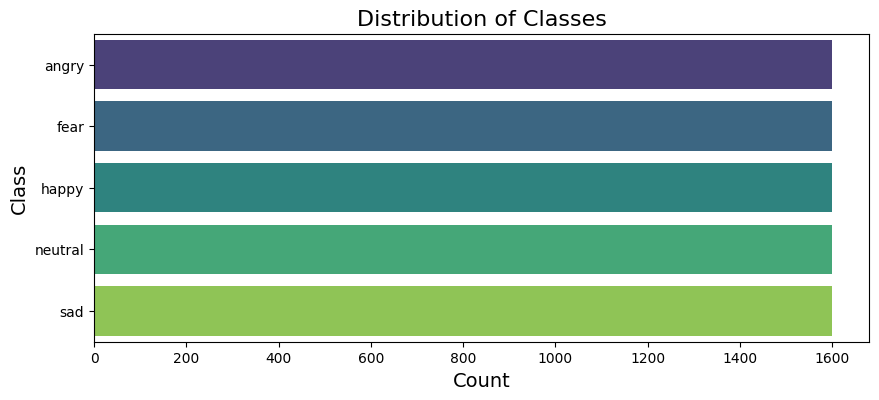

In [156]:
# Plotting count distribution of classes
plt.figure(figsize=(10, 4))
sns.countplot(y=df['label'], palette='viridis')
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.show()
